---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Yuxuan Chen
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: "2025-4-7"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [2]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

your 131072x1 screen size is bogus. expect trouble


25/04/07 02:06:35 WARN Utils: Your hostname, DESKTOP-AEE21PF resolves to a loopback address: 127.0.1.1; using 192.168.167.208 instead (on interface eth0)
25/04/07 02:06:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/04/07 02:06:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [3]:
#| eval: false
#| echo: true
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

df = df.dropna(subset=['EMPLOYMENT_TYPE_NAME', 'SALARY', 'MIN_YEARS_EXPERIENCE', 'DURATION'])

categorical_cols = ['EMPLOYMENT_TYPE_NAME']

numeric_cols = ['MIN_YEARS_EXPERIENCE', 'DURATION']

indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid='skip') for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec") for c in categorical_cols]

assembler = VectorAssembler(
    inputCols=[f"{c}_vec" for c in categorical_cols] + numeric_cols,
    outputCol="features"
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])

model = pipeline.fit(df)
data = model.transform(df)

data = data.select("SALARY", "features")
data.show(5, False)



+------+-------------------+
|SALARY|features           |
+------+-------------------+
|192800|[1.0,0.0,6.0,55.0] |
|125900|[1.0,0.0,12.0,18.0]|
|118560|[1.0,0.0,5.0,20.0] |
|192800|[1.0,0.0,6.0,55.0] |
|116500|[1.0,0.0,12.0,16.0]|
+------+-------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [4]:
#| eval: true
#| echo: false
train_data, test_data = data.randomSplit([0.8, 0.2], seed=688)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(11564, 2)


(2852, 2)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [5]:
#| eval: false
#| echo: false
from pyspark.ml.regression import LinearRegression

feature_names = assembler.getInputCols()

lr = LinearRegression(featuresCol="features", labelCol="SALARY")
lr_model = lr.fit(train_data)
summary = lr_model.summary

# Coefficients and Intercept
# print("Intercept: {:.4f}".format(glr_model.intercept))
# print("Coefficients:")
# for i, coef in enumerate(glr_model.coefficients):
#     print(f"  Feature {i + 1}: {coef:.4f}")

# Summary stats
# print("\n--- Regression Summary ---")
# print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
# print("T Values:", [f"{val:.4f}" for val in summary.tValues])
# print("P Values:", [f"{val:.4f}" for val in summary.pValues])

# print(f"\nDispersion: {summary.dispersion:.4f}")
# print(f"Null Deviance: {summary.nullDeviance:.4f}")
# print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
# print(f"Deviance: {summary.deviance:.4f}")
# print(f"Residual DF: {summary.residualDegreeOfFreedom}")
# print(f"AIC: {summary.aic:.4f}")

# 1. Pull feature names directly from Java backend
features_col = lr_model.getFeaturesCol()
field = data.schema[features_col]
if "ml_attr" in field.metadata:  # 如果是 VectorAssembler 生成的列
    attrs = field.metadata["ml_attr"]["attrs"]
    feature_names = [attr["name"] for key in attrs for attr in attrs[key]]
else:  # 如果是普通列
    feature_names = [features_col]

# 2. Construct full table including intercept
features = ["Intercept"] + feature_names
coefs = [lr_model.intercept] + list(lr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)

25/04/07 02:06:53 WARN Instrumentation: [87568650] regParam is zero, which might cause numerical instability and overfitting.


## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [7]:
#| eval: true
#| echo: false
import pandas as pd
from tabulate import tabulate
import pandas as pd


coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": coefs,
    "Std Error": se,
    "t-stat": tvals,
    "P-Value": pvals
})

# 4. Optional pretty print
print(tabulate(coef_table, headers="keys", tablefmt="pretty"))

# 5. Save for report
# coef_table.to_csv("_output/glr_summary_pretty.csv", index=False)


+---+---------------------------------------------------+---------------------+--------------------+-----------------------+---------------------+
|   |                      Feature                      |      Estimate       |     Std Error      |        t-stat         |       P-Value       |
+---+---------------------------------------------------+---------------------+--------------------+-----------------------+---------------------+
| 0 |                     Intercept                     |   81712.314367228   | 2962.2422303045855 |  0.7308865996719746   | 0.4648632360875571  |
| 1 |               MIN_YEARS_EXPERIENCE                | 2165.0631511120446  | 3555.097038590949  | -0.050092509310951244 | 0.9600495344523194  |
| 2 |                     DURATION                      | -178.08373150695232 | 101.79112580002139 |   65.79705025810176   |         0.0         |
| 3 |  EMPLOYMENT_TYPE_NAME_vec_Full-time (> 32 hours)  |  6697.555820092767  | 23.458415204387137 |  -1.0367409976681

Estimate (Coefficient)：DURATION shows a strong negative impact on salary (~$178 per unit), making it a key factor. Full-time increases salary by ~$6,697, but its effect isn’t clearly significant. MIN_YEARS_EXPERIENCE and Part-time have small coefficients with limited impact.

Std Error：DURATION has low standard error, meaning stable estimation. MIN_YEARS_EXPERIENCE and Part-time have large errors, suggesting unreliable coefficients. Full-time is stable but not statistically useful.

t-stat：High t-values for DURATION and Part-time confirm strong effects. MIN_YEARS_EXPERIENCE and Full-time have t-values near zero, indicating weak or no contribution to the model.

P-Value：Only DURATION and Part-time are statistically significant (p = 0). MIN_YEARS_EXPERIENCE and Full-time are not significant.

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


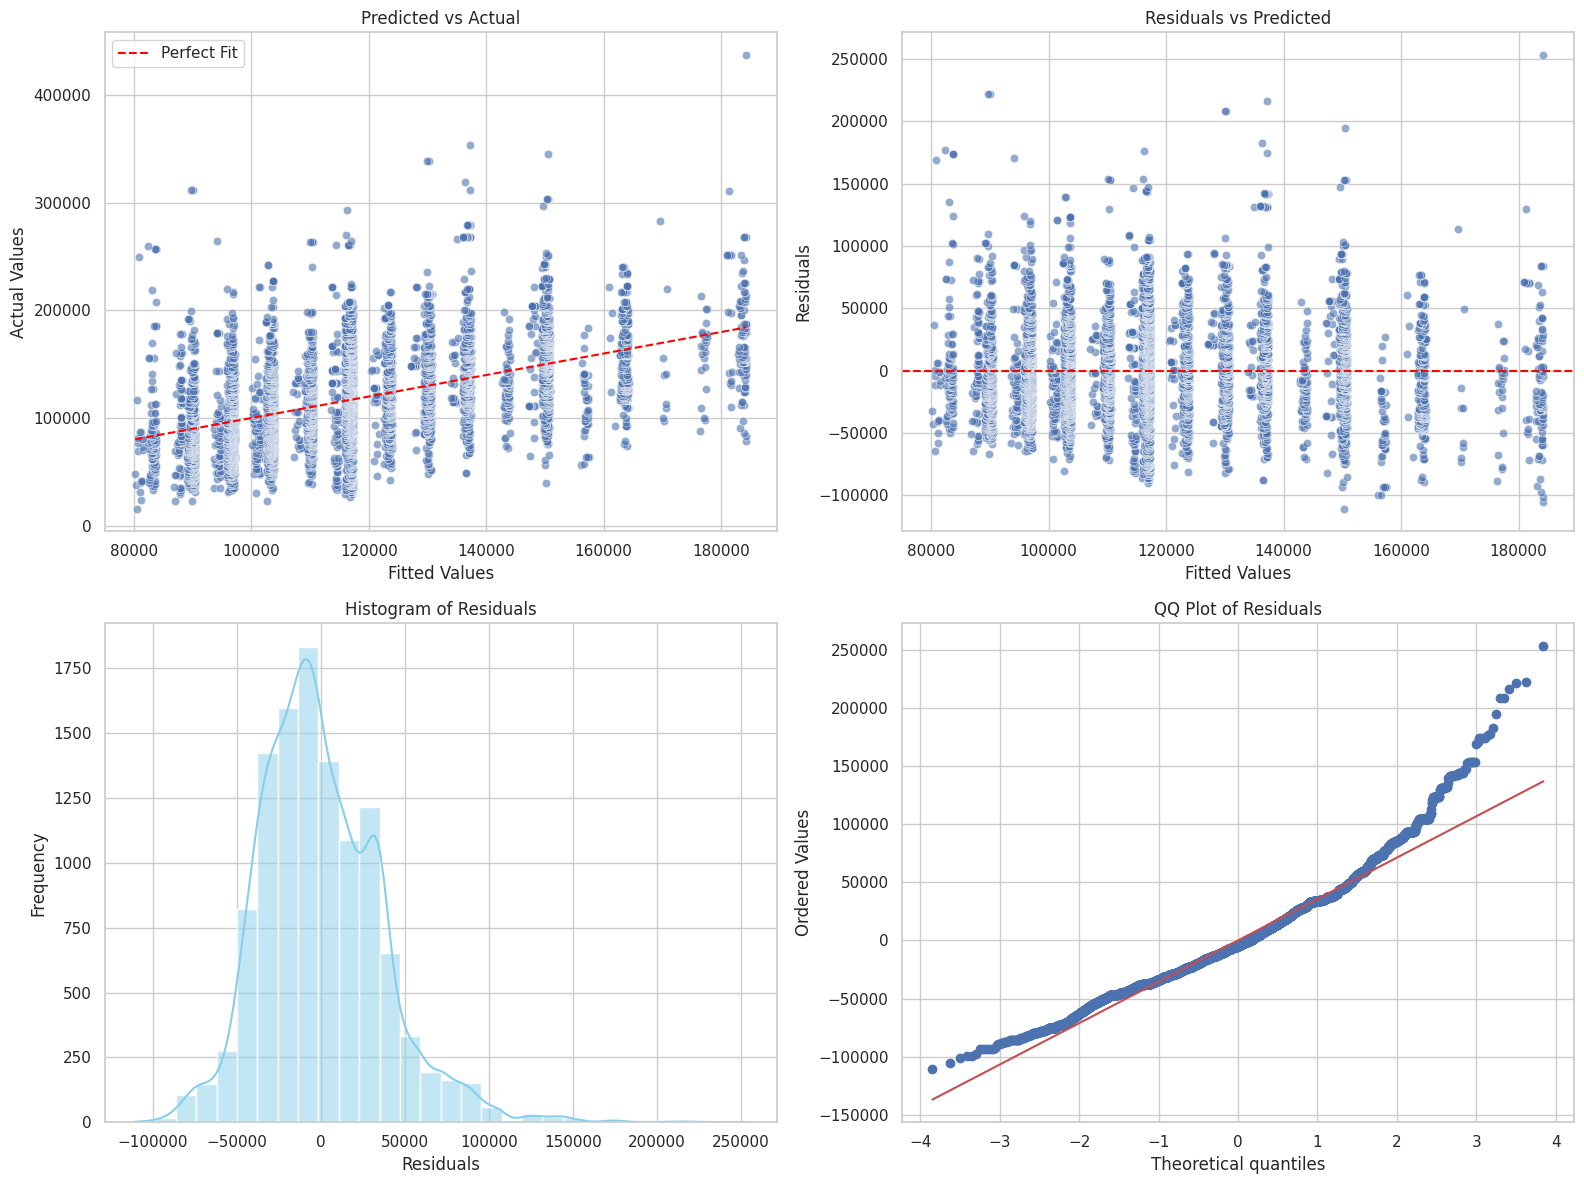

In [99]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load predictions from GLR model（添加.collect()转换）
df_pred = summary.predictions.select(
    col("SALARY").alias("actual"),
    col("prediction").alias("fitted")
).collect() 
# 转换为Pandas DataFrame
df_pred = pd.DataFrame([row.asDict() for row in df_pred])

# Compute residuals
df_pred["residuals"] = df_pred["actual"] - df_pred["fitted"]
#df_pred["fitted"] = 

# Standardized residuals
res_mean = df_pred["residuals"].mean()
res_std = df_pred["residuals"].std()
df_pred["std_residuals"] = (df_pred["residuals"] - res_mean) / res_std

# Square root of standardized residuals (for Scale-Location)
df_pred["sqrt_std_resid"] = np.sqrt(np.abs(df_pred["std_residuals"]))


plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

# 1. Predicted vs Actual Plot
plt.subplot(2, 2, 1)
sns.scatterplot(data=df_pred, x="fitted", y="actual", alpha=0.6)
plt.plot([df_pred["fitted"].min(), df_pred["fitted"].max()],
         [df_pred["fitted"].min(), df_pred["fitted"].max()],
         color="red", linestyle="--", label="Perfect Fit")
plt.title("Predicted vs Actual")
plt.xlabel("Fitted Values")
plt.ylabel("Actual Values")
plt.legend()

# 2. Residuals vs Predicted Plot
plt.subplot(2, 2, 2)
sns.scatterplot(data=df_pred, x="fitted", y="residuals", alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

# 3. Histogram of Residuals
plt.subplot(2, 2, 3)
sns.histplot(df_pred["residuals"], kde=True, bins=30, color="skyblue")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

# 4. QQ Plot of Residuals
plt.subplot(2, 2, 4)
stats.probplot(df_pred["residuals"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")


plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [ ]:
#| eval: true
#| echo: false
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

pred_glr = lr_model.transform(test_data)

# R²
r2_eval = RegressionEvaluator(
    labelCol="SALARY", 
    predictionCol="prediction",
    metricName="r2"
)
r2 = r2_eval.evaluate(pred_glr)



# AIC from GLR summary
#aic = lr_model.summary.aic
# 手动计算AIC/BIC
n = pred_glr.count()  # 样本数量
k = len(lr_model.coefficients) + (1 if lr_model.getFitIntercept() else 0)  # 特征数 + 截距项

# 计算残差平方和 (RSS)
residuals_df = pred_glr.withColumn("residual_sq", pow(col("SALARY") - col("prediction"), 2))
rss = residuals_df.agg({"residual_sq": "sum"}).first()[0]

# 计算对数似然 (假设正态分布)
log_likelihood = -n/2 * (np.log(2 * np.pi * rss/n) + 1)

# 计算AIC/BIC
aic = 2 * k - 2 * log_likelihood
bic = np.log(n) * k - 2 * log_likelihood




# BIC calculation
n = pred_glr.count() 
k = len(lr_model.coefficients) + 1
rss = pred_glr.withColumn("residual_sq", pow(col("SALARY") - col("prediction"), 2)) \
             .agg({"residual_sq": "sum"}).first()[0]
bic = n * np.log(rss/n) + k * np.log(n)


# RMSE manually
rmse_eval = RegressionEvaluator(
    labelCol="SALARY",
    predictionCol="prediction",
    metricName="rmse"
)
rmse = rmse_eval.evaluate(pred_glr)

## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

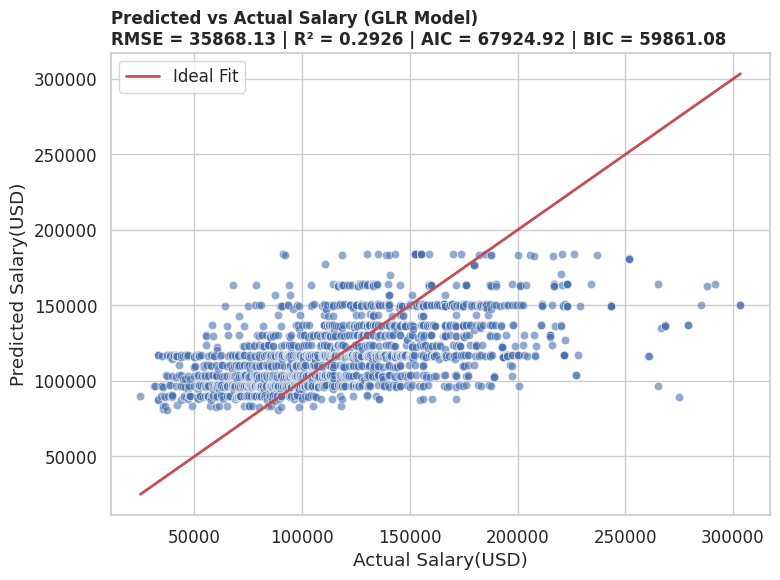

In [107]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert GLR predictions to pandas
pandas_df = pred_glr.select("SALARY", "prediction").collect()
pandas_df = pd.DataFrame(
    [row.asDict() for row in pandas_df],  # 行转字典
    columns=["SALARY", "prediction"]
)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="SALARY", y="prediction", data=pandas_df, alpha=0.6)
plt.plot([pandas_df.SALARY.min(), pandas_df.SALARY.max()], 
         [pandas_df.SALARY.min(), pandas_df.SALARY.max()], 
         'r', linewidth=2, label='Ideal Fit')
plt.xlabel("Actual Salary(USD)")
plt.ylabel("Predicted Salary(USD)")
plt.title(f"Predicted vs Actual Salary (GLR Model)\nRMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}", 
          loc="left", fontsize=12, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()

The plot illustrates the relationship between predicted and actual salaries using a GLR model. The red line represents the ideal fit where predicted values perfectly match actual values. The scatter plot shows a moderate dispersion of points around the ideal line, indicating some predictive accuracy but also suggesting room for improvement. Key metrics include an RMSE of 35868.13, suggesting average prediction error, an R² value of 0.2926 indicating a moderate fit, and AIC and BIC values of 67924.92 and 59861.08, respectively, which are used for model comparison. Overall, while the model shows some predictive power, there is significant variability in the data.

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
